# E16: The Binomial Distribution - Modeling Success Counts

**Objective:** This notebook explores the Binomial distribution, a cornerstone for modeling the number of successes in a fixed set of trials. Building upon the Bernoulli process, we will analyze how the distribution's shape and properties change with its parameters, `n` (number of trials) and `p` (probability of success).

Our journey involves:
1.  **Visualization:** Plotting the Probability Mass Function (PMF) and Cumulative Distribution Function (CDF) for different parameter sets to build an intuition for their shape.
2.  **Verification:** Calculating the mean and variance directly from the PMF and verifying they match the well-known theoretical formulas, `np` and `np(1-p)`.
3.  **Calculation:** Using the CDF to compute tail probabilities, a common task in reliability (e.g., "What is the probability of at least k failures?").
4.  **Approximation:** Investigating the Normal approximation to the Binomial distribution, a powerful tool for large-scale scenarios, and understanding the importance of the continuity correction.

### 1. Setup

We'll import the necessary libraries, including `scipy.stats` which provides robust functions for working with dozens of probability distributions. We also define the parameter sets from `Table 10`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

# Set a professional and clean style for our plots
plt.style.use('seaborn-v0_8-whitegrid')

# Parameter sets from Table 10
cases = {
    'A': {'n': 20, 'p': 0.20, 'k': 6},
    'B': {'n': 20, 'p': 0.50, 'k': 12},
    'C': {'n': 20, 'p': 0.80, 'k': 16},
    'D': {'n': 100, 'p': 0.30, 'k': 40}
}

### (a) & (b) Plotting the PMF and CDF

Let's visualize the four Binomial distributions. We'll plot the PMF and CDF for each case. On the PMF, we'll mark the theoretical mean (`np`) and mode (`floor((n+1)p)`) to see how they describe the center of the distribution.

Notice how the shape changes:
-   Case A (p=0.2) is skewed to the right.
-   Case B (p=0.5) is perfectly symmetric.
-   Case C (p=0.8) is skewed to the left.
-   Case D (large n) is symmetric and bell-shaped, hinting at the Normal approximation.

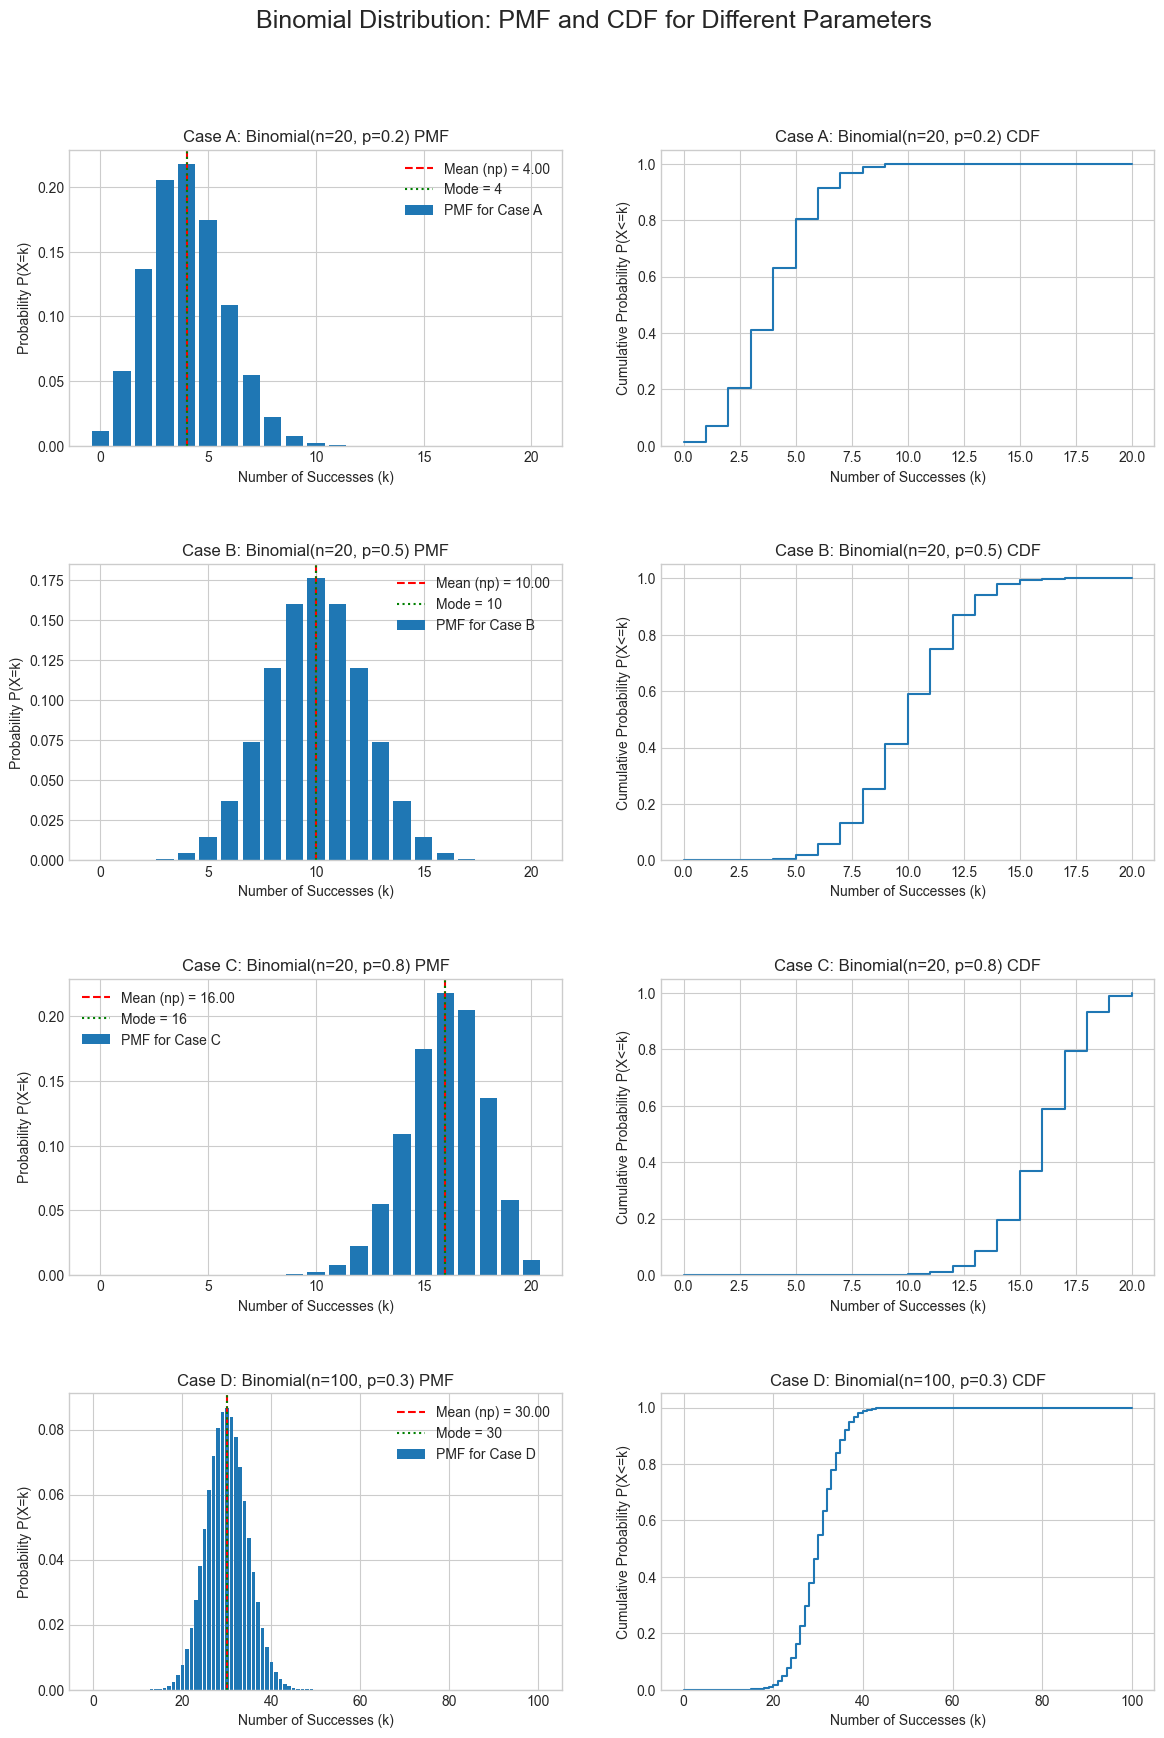

In [2]:
# Create a figure to hold the plots for all cases
fig, axes = plt.subplots(4, 2, figsize=(14, 20), gridspec_kw={'hspace': 0.4, 'wspace': 0.2})
fig.suptitle('Binomial Distribution: PMF and CDF for Different Parameters', fontsize=18, y=0.95)

for i, (case_id, params) in enumerate(cases.items()):
    n, p = params['n'], params['p']
    
    # Generate x values (number of successes) from 0 to n
    x = np.arange(0, n + 1)
    
    # Calculate PMF and CDF using scipy
    pmf = binom.pmf(x, n, p)
    cdf = binom.cdf(x, n, p)
    
    # --- PMF Plot ---
    ax_pmf = axes[i, 0]
    ax_pmf.bar(x, pmf, label=f'PMF for Case {case_id}')
    ax_pmf.set_title(f'Case {case_id}: Binomial(n={n}, p={p}) PMF')
    ax_pmf.set_xlabel('Number of Successes (k)')
    ax_pmf.set_ylabel('Probability P(X=k)')
    
    # Mark mean and mode
    mean = n * p
    mode = np.floor((n + 1) * p)
    ax_pmf.axvline(mean, color='red', linestyle='--', label=f'Mean (np) = {mean:.2f}')
    ax_pmf.axvline(mode, color='green', linestyle=':', label=f'Mode = {mode:.0f}')
    ax_pmf.legend()
    
    # --- CDF Plot ---
    ax_cdf = axes[i, 1]
    ax_cdf.step(x, cdf, where='post', label=f'CDF for Case {case_id}')
    ax_cdf.set_title(f'Case {case_id}: Binomial(n={n}, p={p}) CDF')
    ax_cdf.set_xlabel('Number of Successes (k)')
    ax_cdf.set_ylabel('Cumulative Probability P(X<=k)')
    ax_cdf.set_ylim(0, 1.05)
    
plt.show()

### (c) Verifying Moments (Mean and Variance)

Now, let's confirm that the fundamental formulas for mean and variance hold true. We will calculate them directly from the PMF we generated (`E[X] = sum(x * P(X=x))`) and compare the results to the simple theoretical formulas (`np` and `np(1-p)`). This is a great way to build confidence in both the theory and our implementation.

In [3]:
print("--- Verification of Mean and Variance ---")
for case_id, params in cases.items():
    n, p = params['n'], params['p']
    x = np.arange(0, n + 1)
    pmf = binom.pmf(x, n, p)
    
    # --- Calculations from PMF definition ---
    calc_mean = np.sum(x * pmf)
    calc_var = np.sum((x - calc_mean)**2 * pmf)
    
    # --- Theoretical formulas ---
    theory_mean = n * p
    theory_var = n * p * (1 - p)
    
    print(f"\nCase {case_id} (n={n}, p={p}):")
    print(f"  Mean:      Calculated={calc_mean:.4f}, Theoretical={theory_mean:.4f}")
    print(f"  Variance:  Calculated={calc_var:.4f}, Theoretical={theory_var:.4f}")
    
    # Verification
    assert np.isclose(calc_mean, theory_mean)
    assert np.isclose(calc_var, theory_var)
    print("  ✅ Verification successful.")

--- Verification of Mean and Variance ---

Case A (n=20, p=0.2):
  Mean:      Calculated=4.0000, Theoretical=4.0000
  Variance:  Calculated=3.2000, Theoretical=3.2000
  ✅ Verification successful.

Case B (n=20, p=0.5):
  Mean:      Calculated=10.0000, Theoretical=10.0000
  Variance:  Calculated=5.0000, Theoretical=5.0000
  ✅ Verification successful.

Case C (n=20, p=0.8):
  Mean:      Calculated=16.0000, Theoretical=16.0000
  Variance:  Calculated=3.2000, Theoretical=3.2000
  ✅ Verification successful.

Case D (n=100, p=0.3):
  Mean:      Calculated=30.0000, Theoretical=30.0000
  Variance:  Calculated=21.0000, Theoretical=21.0000
  ✅ Verification successful.


### (d) Calculating Tail Probabilities

A common question is "what is the probability of observing *at least* k successes?". This is a tail probability, `P(X >= k)`. We can easily calculate this using the CDF: since `CDF(k-1)` gives us `P(X <= k-1)`, the complementary probability is `1 - CDF(k-1)`.

In [4]:
print("--- Tail Probability Calculations: P(X >= k) ---")
for case_id, params in cases.items():
    n, p, k = params['n'], params['p'], params['k']
    
    # P(X >= k) = 1 - P(X <= k-1)
    prob = 1 - binom.cdf(k - 1, n, p)
    
    print(f"  Case {case_id}: P(X >= {k} | n={n}, p={p}) = {prob:.4f}")

--- Tail Probability Calculations: P(X >= k) ---
  Case A: P(X >= 6 | n=20, p=0.2) = 0.1958
  Case B: P(X >= 12 | n=20, p=0.5) = 0.2517
  Case C: P(X >= 16 | n=20, p=0.8) = 0.6296
  Case D: P(X >= 40 | n=100, p=0.3) = 0.0210


### (e) Normal Approximation

For Case D (n=100, p=0.30), the number of trials is large, making it a perfect candidate for the Normal approximation. Let's approximate `P(X >= 40)` using a Normal distribution and apply the **continuity correction** for better accuracy.

The Binomial `P(X >= 40)` corresponds to the discrete bars for 40, 41, ..., 100. To approximate this with a continuous curve, we start the integration from `39.5`. So, we calculate `P(Y > 39.5)`, where `Y` is the approximating Normal variable.

Finally, we'll overlay the Normal PDF on the Binomial PMF to visually confirm how well it fits.

--- Normal Approximation for Case D (n=100, p=0.30, k=40) ---
Exact Binomial Probability P(X >= 40): 0.020989
Normal Approximation P(Y > 39.5):    0.019083
Approximation Error: 0.001906


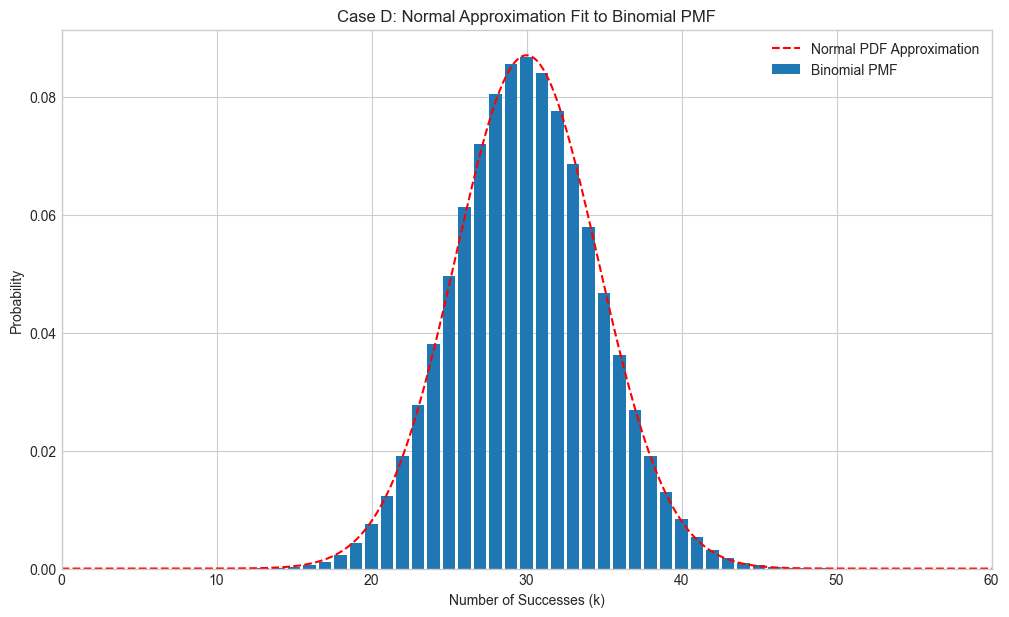

In [5]:
# --- Normal Approximation for Case D ---
params_d = cases['D']
n, p, k = params_d['n'], params_d['p'], params_d['k']

# 1. Calculate exact probability (from previous part)
exact_prob = 1 - binom.cdf(k - 1, n, p)

# 2. Set up the Normal approximation
mu = n * p
sigma = np.sqrt(n * p * (1 - p))

# 3. Calculate approximated probability with continuity correction
# P(X >= 40) is approximated by P(Y > 39.5)
approx_prob = 1 - norm.cdf(39.5, loc=mu, scale=sigma)

print("--- Normal Approximation for Case D (n=100, p=0.30, k=40) ---")
print(f"Exact Binomial Probability P(X >= 40): {exact_prob:.6f}")
print(f"Normal Approximation P(Y > 39.5):    {approx_prob:.6f}")
print(f"Approximation Error: {abs(exact_prob - approx_prob):.6f}")


# --- Visualizing the Fit ---
x = np.arange(0, n + 1)
pmf_d = binom.pmf(x, n, p)

# For a smooth curve, generate more points for the normal PDF
x_norm = np.linspace(0, n, 500)
pdf_norm = norm.pdf(x_norm, loc=mu, scale=sigma)

plt.figure(figsize=(12, 7))
plt.bar(x, pmf_d, label='Binomial PMF')
plt.plot(x_norm, pdf_norm, color='red', linestyle='--', label='Normal PDF Approximation')
plt.title('Case D: Normal Approximation Fit to Binomial PMF')
plt.xlabel('Number of Successes (k)')
plt.ylabel('Probability')
plt.xlim(0, 60) # Zoom in on the relevant area
plt.legend()
plt.show()